In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
# Set style for plots
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [ ]:
# Load dataset
file_path = "/content/BOB Historical Data.csv"
df = pd.read_csv(file_path)

In [ ]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
print(df)

         Date   Price    Open    High     Low    Vol. Change %
0  2025-02-13  212.82  212.98  214.20  212.52   1.32M    0.13%
1  2025-02-12  212.54  212.90  214.20  205.71   8.73M    0.83%
2  2025-02-11  210.78  216.00  216.99  209.50   5.67M   -2.07%
3  2025-02-10  215.23  216.50  217.16  213.64   4.29M   -0.50%
4  2025-02-07  216.32  220.00  220.82  215.05   9.56M   -1.54%
5  2025-02-06  219.71  221.60  222.58  218.01  10.17M   -0.14%
6  2025-02-05  220.02  215.00  221.11  214.12  15.76M    3.35%
7  2025-02-04  212.89  210.50  214.50  210.11  12.13M    2.36%
8  2025-02-03  207.99  211.09  211.09  206.55  13.27M   -1.35%
9  2025-02-01  210.84  216.00  216.42  207.61  16.15M   -1.19%
10 2025-01-31  213.39  218.50  218.50  211.05  50.87M   -4.05%
11 2025-01-30  222.39  223.90  225.84  221.69  10.81M   -0.09%
12 2025-01-29  222.59  222.70  224.90  221.07   8.51M    0.37%
13 2025-01-28  221.76  224.50  225.29  220.10  12.79M    0.97%
14 2025-01-27  219.62  223.00  224.87  218.45   7.82M  

In [ ]:
# Step 2: Convert 'Change %' to float (robust version)
df['Change %'] = df['Change %'].astype(str).str.replace('%', '', regex=False)
df['Change %'] = pd.to_numeric(df['Change %'], errors='coerce')
print("After cleaning 'Change %':")
print(df[['Change %']].head(), "\n")

After cleaning 'Change %':
   Change %
0     -3.42
1      2.77
2     -0.76
3      3.08
4     -0.37 



In [ ]:
# Step 3: Convert 'Vol.' to numeric
def convert_volume(vol):
    if isinstance(vol, str):
        vol = vol.replace('M', 'e6').replace('K', 'e3')
        try:
            return float(eval(vol))
        except:
            return np.nan
    return vol

df['Vol.'] = df['Vol.'].apply(convert_volume)
print("After converting 'Vol.':")
print(df[['Vol.']].head(), "\n")

After converting 'Vol.':
         Vol.
0  14380000.0
1  10790000.0
2   8410000.0
3  13040000.0
4   6060000.0 



In [ ]:
# Step 4: Sort by date ascending
df = df.sort_values(by='Date').reset_index(drop=True)
print("After sorting by date (ascending):")
print(df[['Date', 'Price']].head(), "\n")

After sorting by date (ascending):
        Date   Price
0 2025-01-24  225.21
1 2025-01-27  219.62
2 2025-01-28  221.76
3 2025-01-29  222.59
4 2025-01-30  222.39 



In [ ]:
# Step 5: Feature Engineering
df['Price_lag1'] = df['Price'].shift(1)
df['Change_lag1'] = df['Change %'].shift(1)
df['MA_5'] = df['Price'].rolling(window=5).mean()
df['MA_10'] = df['Price'].rolling(window=10).mean()
df['STD_5'] = df['Price'].rolling(window=5).std()
df['Daily Return'] = df['Price'].pct_change()
df['Range'] = df['High'] - df['Low']
print("After feature engineering:")
print(df[['Price_lag1', 'MA_5', 'STD_5', 'Daily Return', 'Range']].tail(), "\n")

After feature engineering:
    Price_lag1     MA_5     STD_5  Daily Return  Range
20      219.71  215.386  5.049112     -0.015429   5.77
21      216.32  216.834  3.033732     -0.005039   3.52
22      215.23  216.412  3.775562     -0.020676   7.49
23      210.78  214.916  3.457026      0.008350   8.49
24      212.54  213.538  2.220387      0.001317   1.68 



In [ ]:
# Step 6: Time-based features
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
print("After extracting time-based features:")
print(df[['Date', 'DayOfWeek', 'Month']].head(), "\n")

After extracting time-based features:
         Date  DayOfWeek  Month
9  2025-01-24          4      1
10 2025-01-27          0      1
11 2025-01-28          1      1
12 2025-01-29          2      1
13 2025-01-30          3      1 



In [ ]:
# Step 7: Handle missing values (drop for simplicity)
df = df.dropna()
print("After dropping missing values:")
print(df.head(), "\n")


After dropping missing values:
         Date   Price    Open    High     Low        Vol.  Change %  \
9  2025-01-24  225.21  228.36  230.01  224.60   7500000.0     -1.72   
10 2025-01-27  219.62  223.00  224.87  218.45   7820000.0     -2.48   
11 2025-01-28  221.76  224.50  225.29  220.10  12790000.0      0.97   
12 2025-01-29  222.59  222.70  224.90  221.07   8510000.0      0.37   
13 2025-01-30  222.39  223.90  225.84  221.69  10810000.0     -0.09   

    Price_lag1  Change_lag1     MA_5    MA_10     STD_5  Daily Return  Range  \
9       229.16         0.34  228.896  226.476  2.491311     -0.017237   5.41   
10      225.21        -1.72  226.396  226.669  4.160124     -0.024821   6.42   
11      219.62        -2.48  224.826  226.473  4.125067      0.009744   5.19   
12      221.76         0.97  223.668  226.530  3.664992      0.003743   3.83   
13      222.59         0.37  222.314  225.884  2.002081     -0.000899   4.15   

    DayOfWeek  Month  
9           4      1  
10          0  

In [ ]:
# Step 8: Feature Scaling
scaler = StandardScaler()
columns_to_scale = ['Price', 'Open', 'High', 'Low', 'Vol.']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
print("After feature scaling:")
print(df[columns_to_scale].head(), "\n")

After feature scaling:
      Price      Open      High       Low      Vol.
0  1.744050  1.951734  1.954817  1.822355 -0.440509
1  0.623931  0.907106  0.960482  0.727741 -0.410576
2  1.052742  1.199446  1.041731  1.021418  0.054311
3  1.219057  0.848638  0.966285  1.194064 -0.346035
4  1.178981  1.082510  1.148129  1.304415 -0.130896 



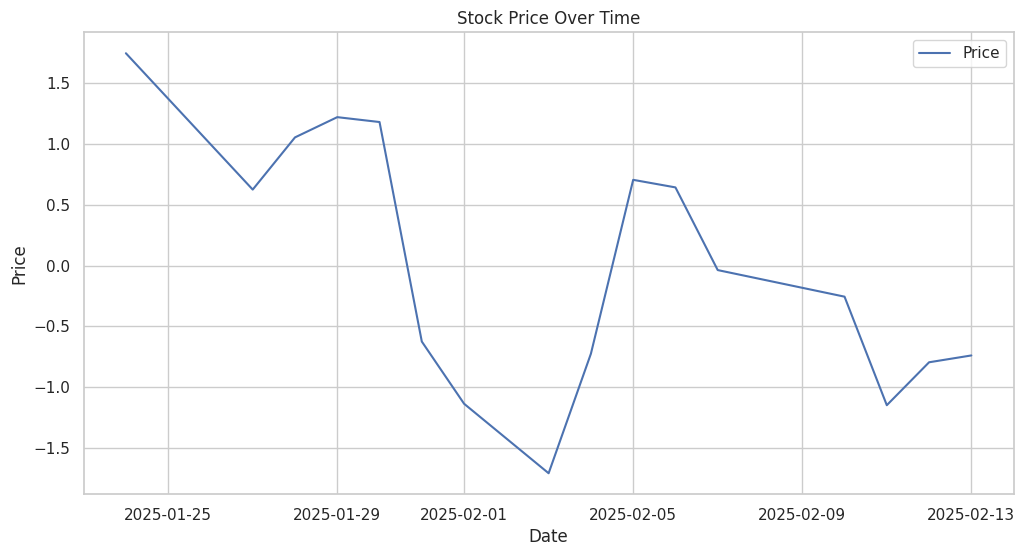

In [ ]:
plt.plot(df['Date'], df['Price'], label='Price')
plt.title("Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

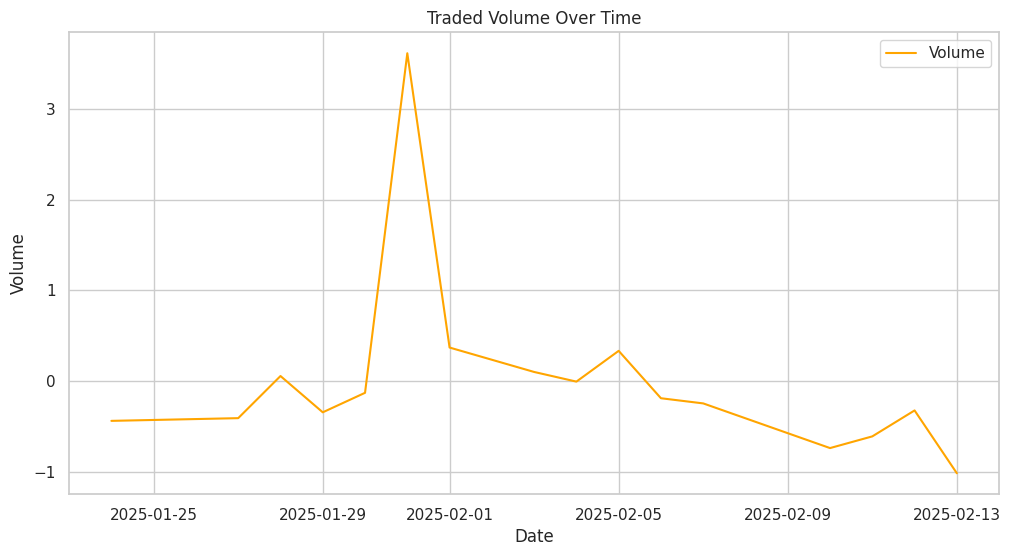

In [ ]:
plt.plot(df['Date'], df['Vol.'], color='orange', label='Volume')
plt.title("Traded Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.show()


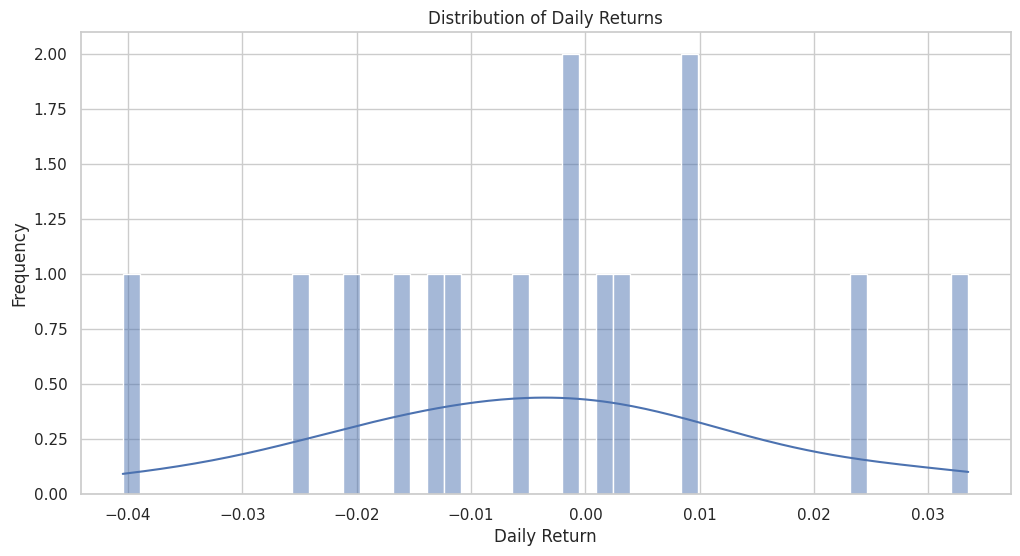

In [ ]:
sns.histplot(df['Daily Return'], bins=50, kde=True)
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()

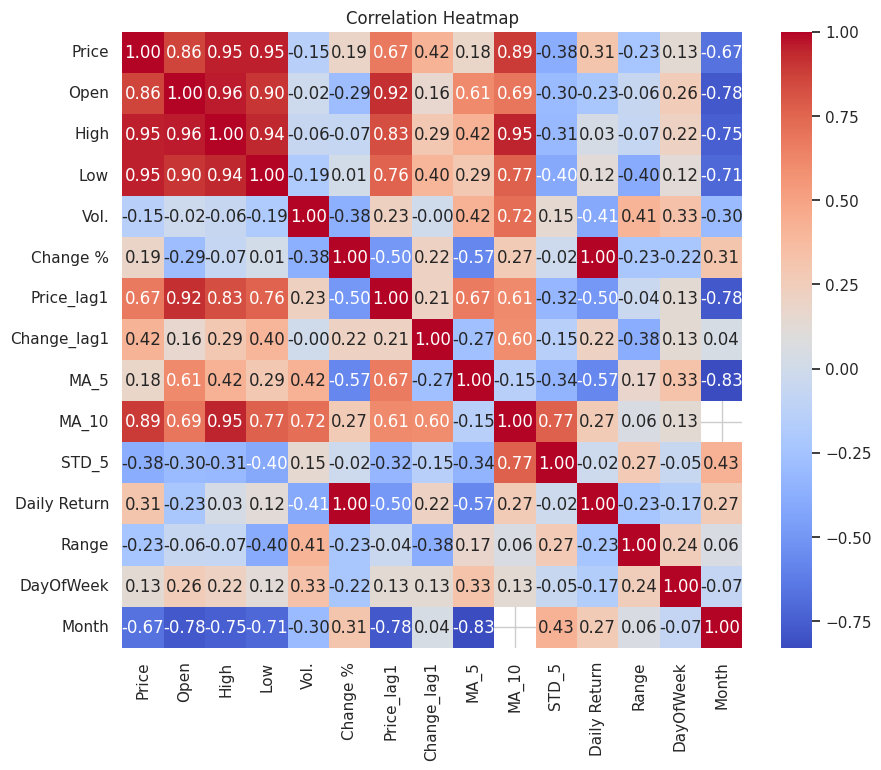

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

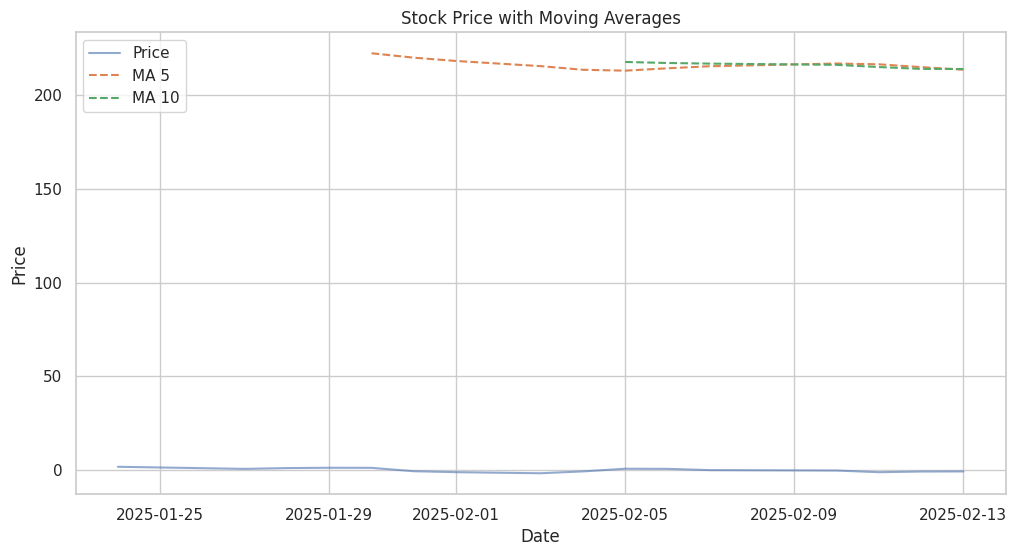

In [ ]:
plt.plot(df['Date'], df['Price'], label='Price', alpha=0.6)
plt.plot(df['Date'], df['MA_5'], label='MA 5', linestyle='--')
plt.plot(df['Date'], df['MA_10'], label='MA 10', linestyle='--')
plt.title("Stock Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

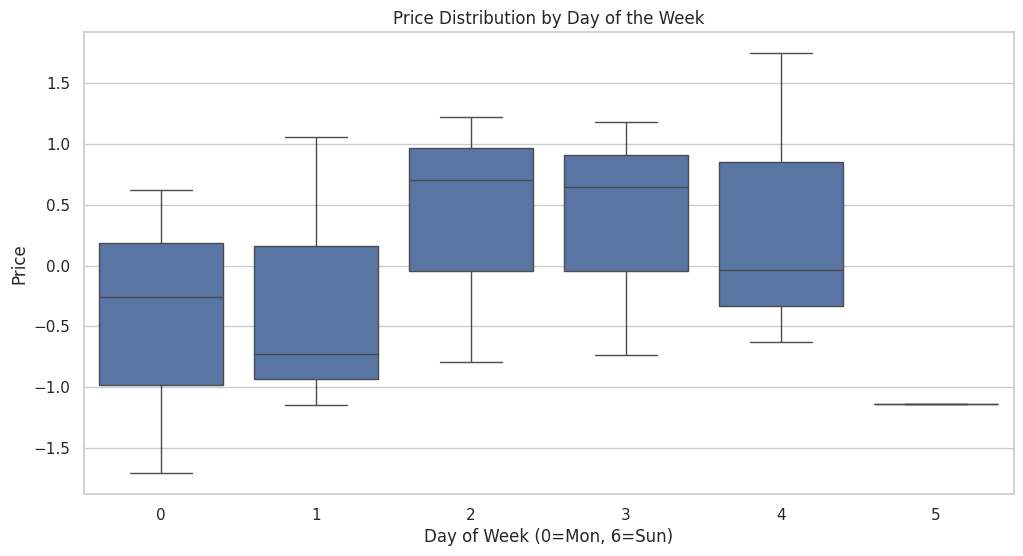

In [ ]:
sns.boxplot(x='DayOfWeek', y='Price', data=df)
plt.title("Price Distribution by Day of the Week")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.ylabel("Price")
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Check on the 'Price' column
result = adfuller(df['Price'])

print("ADF Test Result:")
print(f"ADF Statistic : {result[0]}")
print(f"p-value       : {result[1]}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"\t{key} : {value}")


ADF Test Result:
ADF Statistic : -4.848932781603967
p-value       : 4.3800078338044826e-05
Critical Values:
	1% : -4.223238279489106
	5% : -3.189368925619835
	10% : -2.729839421487603


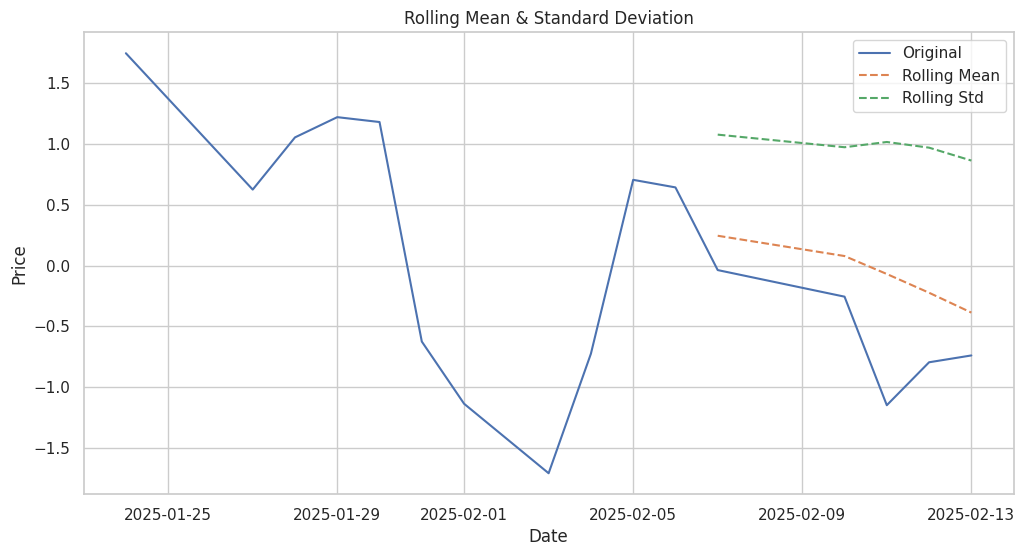

In [ ]:
rolling_mean = df['Price'].rolling(window=12).mean()
rolling_std = df['Price'].rolling(window=12).std()

plt.plot(df['Date'], df['Price'], label='Original')
plt.plot(df['Date'], rolling_mean, label='Rolling Mean', linestyle='--')
plt.plot(df['Date'], rolling_std, label='Rolling Std', linestyle='--')
plt.legend()
plt.title("Rolling Mean & Standard Deviation")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


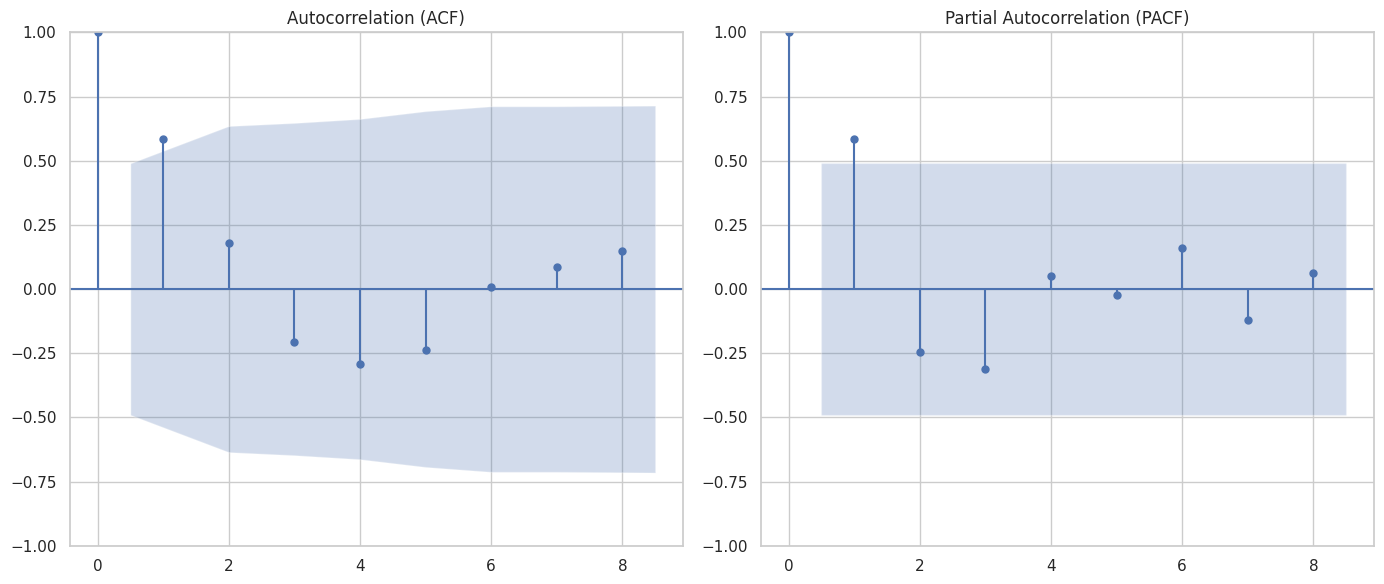

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Drop any NaNs just in case
price_series = df['Price'].dropna()

# Choose lag dynamically
max_lags = min(40, len(price_series) // 2)

# Plot ACF and PACF
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(price_series, ax=plt.gca(), lags=max_lags)
plt.title('Autocorrelation (ACF)')

plt.subplot(1, 2, 2)
plot_pacf(price_series, ax=plt.gca(), lags=max_lags, method='ywm')
plt.title('Partial Autocorrelation (PACF)')

plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

In [ ]:
# Ensure 'Date' is the index
df_arima = df[['Date', 'Price']].copy()
df_arima.set_index('Date', inplace=True)

In [ ]:
pip install pmdarima

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Candidate (p, d, q) values
param_grid = [(1, 0, 1), (2, 0, 1), (2, 0, 2), (3, 0, 2), (4, 0, 2), (5, 0, 2)]
aic_results = []

for order in param_grid:
    try:
        model = ARIMA(df_arima['Price'], order=order)
        model_fit = model.fit()
        aic = model_fit.aic
        aic_results.append((order, aic))
        print(f"ARIMA{order} AIC: {aic:.2f}")
    except Exception as e:
        print(f"Failed for {order}: {e}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1) AIC: 43.62
ARIMA(2, 0, 1) AIC: 44.60


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/di

ARIMA(2, 0, 2) AIC: 43.99


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(3, 0, 2) AIC: 45.49


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(4, 0, 2) AIC: 47.34
ARIMA(5, 0, 2) AIC: 49.31


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#since (1, 0, 1) has the lowest aic
best_order = (1, 0, 1)
final_model = ARIMA(df_arima['Price'], order=best_order).fit()
print(final_model.summary())


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                   16
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -17.811
Date:                Tue, 08 Apr 2025   AIC                             43.623
Time:                        14:15:56   BIC                             46.713
Sample:                             0   HQIC                            43.781
                                 - 16                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1105      0.482      0.229      0.819      -0.833       1.054
ar.L1          0.5716      0.275      2.081      0.037       0.033       1.110
ma.L1          0.3069      0.398      0.771      0.4

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


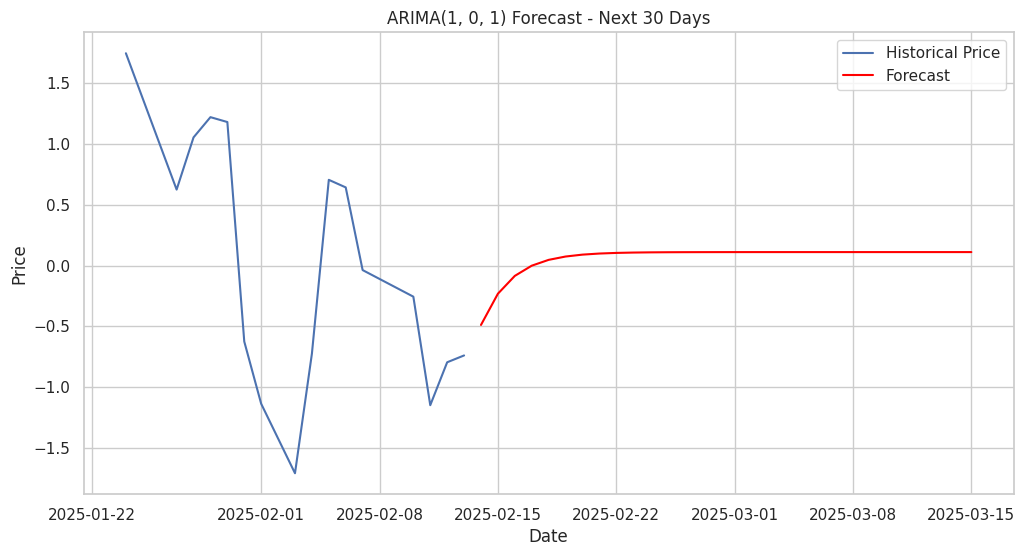

In [ ]:
forecast_steps = 30
forecast = final_model.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=df_arima.index[-1], periods=forecast_steps + 1, freq='D')[1:]

# Plot the forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_arima.index, df_arima['Price'], label='Historical Price')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.title(f"ARIMA{best_order} Forecast - Next 30 Days")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


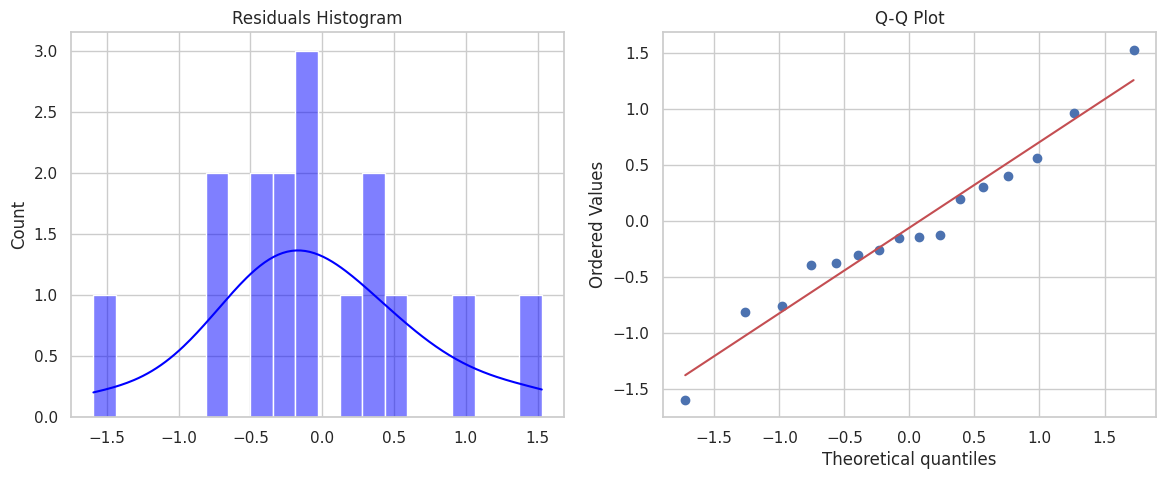

In [ ]:
# 5. Residual Analysis
def plot_residuals():
    residuals = model_fit.resid
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.histplot(residuals, bins=20, kde=True, ax=axes[0], color='blue')
    axes[0].set_title("Residuals Histogram")
    stats.probplot(residuals, dist="norm", plot=axes[1])
    axes[1].set_title("Q-Q Plot")
    plt.show()

plot_residuals()

In [ ]:
predicted = final_model.forecast(steps=30)  # Or however many days you predicted
actuals = df['Price'][-30:]  # Match the length of predicted

# Now you're safe to run:
pred_returns = pd.Series(predicted).pct_change().dropna()
actual_returns = pd.Series(actuals).pct_change().dropna()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Cumulative Return: -122.64%
Annualized Volatility: 10882.94%
Sharpe Ratio (Annualized): -3.04
Max Drawdown: -147.70%


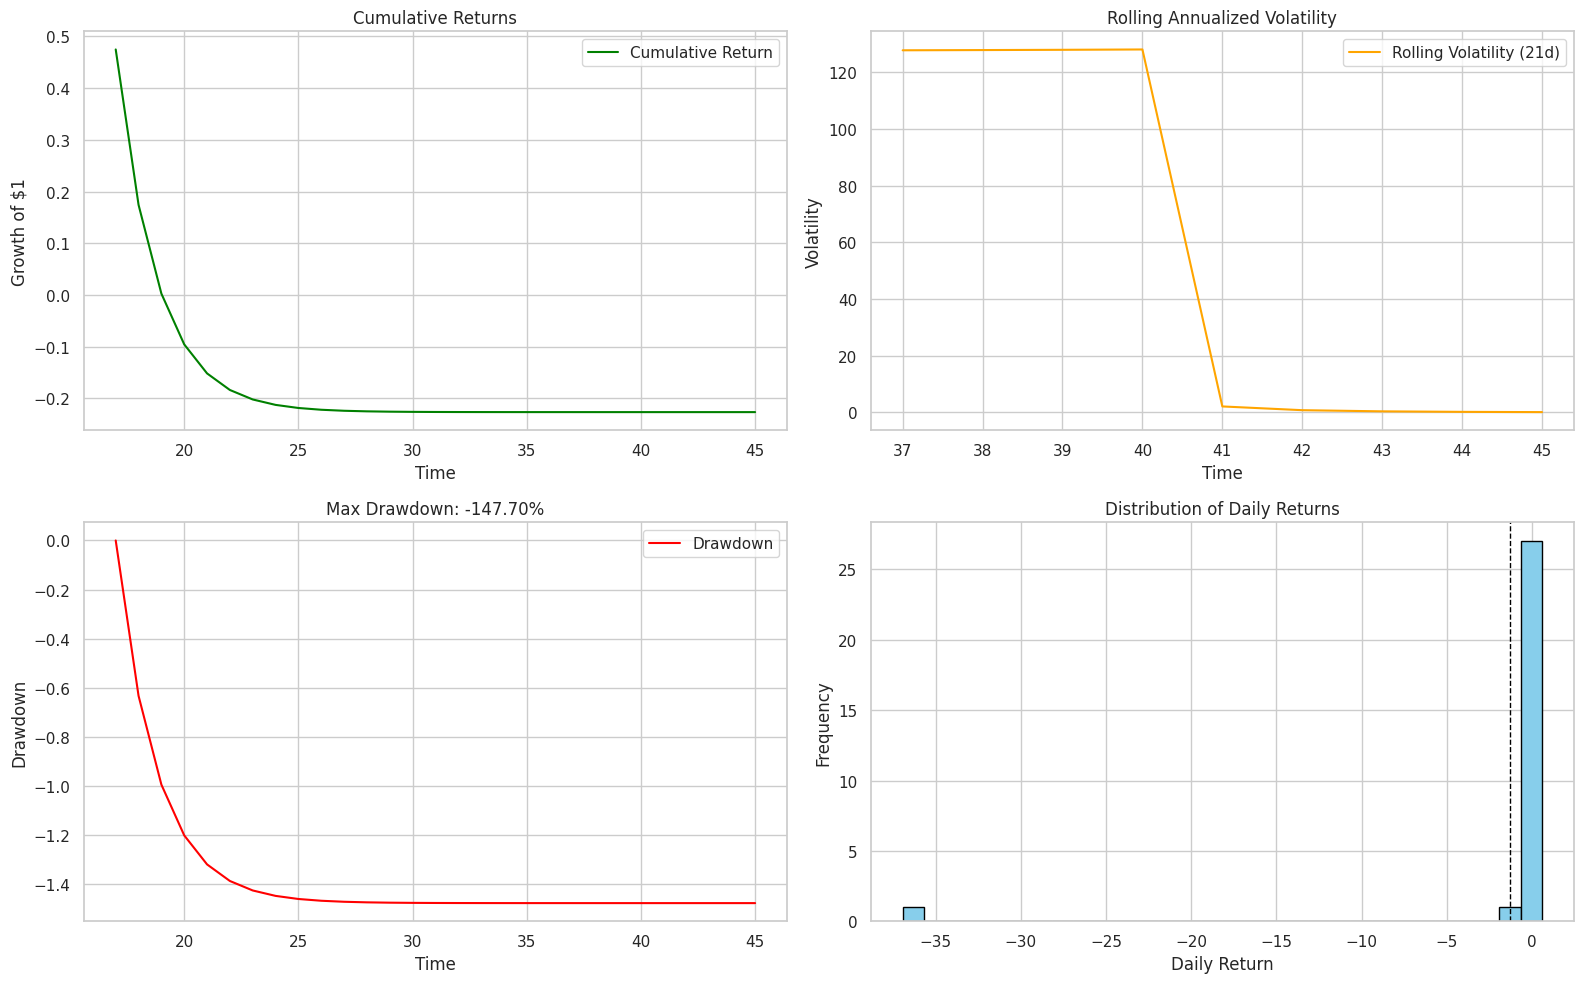

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulated example (replace with your actual prediction/actual values)
# predicted = final_model.forecast(steps=len(actuals))
# actuals = df_arima['Price'][-len(predicted):]

# Daily returns
pred_returns = pd.Series(predicted).pct_change().dropna()
actual_returns = pd.Series(actuals).pct_change().dropna()

# --- Metrics ---
cumulative_return = (pred_returns + 1).prod() - 1
annualized_volatility = pred_returns.std() * np.sqrt(252)
risk_free_rate = 0.03
sharpe_ratio = (pred_returns.mean() - risk_free_rate / 252) / pred_returns.std()
sharpe_ratio_annualized = sharpe_ratio * np.sqrt(252)

cum_returns = (1 + pred_returns).cumprod()
rolling_max = cum_returns.cummax()
drawdown = cum_returns / rolling_max - 1
max_drawdown = drawdown.min()

# --- Print Results ---
print(f"Cumulative Return: {cumulative_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio (Annualized): {sharpe_ratio_annualized:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")

# --- PLOTS ---
plt.figure(figsize=(16, 10))

# 1. Cumulative Returns
plt.subplot(2, 2, 1)
plt.plot(cum_returns, label='Cumulative Return', color='green')
plt.title('Cumulative Returns')
plt.xlabel('Time')
plt.ylabel('Growth of $1')
plt.grid(True)
plt.legend()

# 2. Rolling Volatility
plt.subplot(2, 2, 2)
rolling_vol = pred_returns.rolling(window=21).std() * np.sqrt(252)
plt.plot(rolling_vol, label='Rolling Volatility (21d)', color='orange')
plt.title('Rolling Annualized Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.grid(True)
plt.legend()

# 3. Drawdown
plt.subplot(2, 2, 3)
plt.plot(drawdown, label='Drawdown', color='red')
plt.title(f'Max Drawdown: {max_drawdown:.2%}')
plt.xlabel('Time')
plt.ylabel('Drawdown')
plt.grid(True)
plt.legend()

# 4. Histogram of Returns
plt.subplot(2, 2, 4)
plt.hist(pred_returns, bins=30, color='skyblue', edgecolor='black')
plt.axvline(pred_returns.mean(), color='black', linestyle='dashed', linewidth=1)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:


# Define the time series
ts = df['Price']

# Train-test split (80% train, 20% test)
split_ratio = 0.8
split_index = int(len(ts) * split_ratio)

train = ts[:split_index]
test = ts[split_index:]

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")


Train size: 20
Test size: 5
